<a href="https://colab.research.google.com/github/hubcborja/Proyecto_DataMining_NN/blob/main/Graficacion_red_convenios_Doble_Tributacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graficación de convenios doble tributación

## Importación librerías

In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from sklearn.metrics import roc_auc_score, average_precision_score
pd.set_option('display.max_columns', None)

## Importación datos

Obtenidos de https://www.treaties.tax/en/

ICTD (2021). Tax Treaties Explorer [Online database], Brighton: International Centre for Tax and Development (ICTD), retrieved from https://www.treaties.tax

In [2]:
base_convenios=pd.read_csv('https://raw.githubusercontent.com/hubcborja/Trabajo_grado_ECIJG/refs/heads/main/bases_datos/convenios_tributarios.csv')
base_convenios.head()

,Country A,Country B,Type,Date of signature,Effective,Status,Source,WHTrates,PE,Other,UN,5(3)(a)C,5(3)(a)S,5(3)(b),5(4)(a),5(4)(b),5(5)(b),5(6),5(7),7(1)(b&c),7(3),8(2),10(2)(a)Q,10(2)(a)T,10(2)(b),11(2),11(2)F,12(2),12(2)C,12(2)E,12(A),13(4),13(5),14,16(2),21(3),25B(5),27,29
0,Albania,Israel,Original,2021,2022.0,In Force,0.30,0.31,0.45,0.13,0.26,9.0,YES,12,YES,YES,NO,NO,YES,NO,NO,NO,5,25.0,15,10,10,5,5,5,0,YES,NO,NO,NO,NO,NO,NO,PPT
1,Albania,Turkey,Original,1994,1997.0,In Force,0.19,0.38,0.06,0.13,0.06,12.0,NO,NO,YES,YES,NO,NO,NO,NO,NO,NO,5,25.0,15,10,10,10,10,10,0,NO,NO,YES,NO,NO,NO,NO,NaN
2,Albania,Romania,Original,1994,1995.0,In Force,0.47,0.47,0.58,0.38,0.44,9.0,YES,9,YES,YES,YES,NO,YES,YES,NO,NO,10,25.0,15,10,10,15,15,15,0,NO,NO,YES,NO,YES,NO,NO,NaN
3,Albania,Italy,Original,1994,2000.0,In Force,0.19,0.25,0.19,0.13,0.12,12.0,NO,NO,YES,YES,YES,NO,NO,NO,NO,NO,10,NaN,10,5,5,5,5,5,0,NO,NO,YES,NO,NO,NO,NO,NaN
4,Albania,Russia,Original,1995,1998.0,In Force,0.23,0.38,0.06,0.25,0.12,12.0,NO,NO,YES,YES,NO,NO,NO,NO,NO,NO,10,NaN,10,10,10,10,10,10,0,NO,NO,YES,NO,YES,NO,NO,NaN


In [3]:
base_convenios.columns

Index(['Country A', 'Country B', 'Type', 'Date of signature', 'Effective',
       'Status', 'Source', 'WHTrates', 'PE', 'Other', 'UN', '5(3)(a)C',
       '5(3)(a)S', '5(3)(b)', '5(4)(a)', '5(4)(b)', '5(5)(b)', '5(6)', '5(7)',
       '7(1)(b&c)', '7(3)', '8(2)', '10(2)(a)Q', '10(2)(a)T', '10(2)(b)',
       '11(2)', '11(2)F', '12(2)', '12(2)C', '12(2)E', '12(A)', '13(4)',
       '13(5)', '14', '16(2)', '21(3)', '25B(5)', '27', '29'],
      dtype='object')

In [5]:
# diccionario nombre de las columnas con artículo a nombre del artículo
renombrar_columnas = {
    'Source': 'indice_fuente_total',                   # Que tanto beneficia al pais fuente
    'PE': 'indice_establecimiento_permanente',         # Que tanto se le cobran a los establecimientos permanentes
    'WHT Rates': 'indice_tasas_retencion',             # Que tanto tienen de topes las tasas de retención
    'Other': 'indice_otros_derechos',                  # Indice de los otros derechos del convenio
    'UN': 'indice_modelo_onu',                          # Que tanto se parece al modelo ONU (que favorece a los estado en desarrollo)
    '5(3)(a)C': 'duracion_ep_construccion_meses',      # Construction PE length
    '5(3)(a)S': 'actividades_supervision_ep',          # Supervisory activities in PE
    '5(3)(b)': 'duracion_ep_servicios_meses',          # Service PE length
    '5(4)(a)': 'instalaciones_entrega_excluidas_ep',   # Delivery facilities excluded
    '5(4)(b)': 'inventario_entrega_excluido_ep',       # Delivery stock excluded
    '5(5)(b)': 'agente_con_inventario_ep',             # Agent maintaining stock included
    '5(6)': 'corredor_seguros_ep',                     # Insurance broker included
    '5(7)': 'extension_agente_dependiente_ep',         # Dependent agent extension
    '7(1)(b&c)': 'fuerza_atraccion_limitada',          # Limited force of attraction
    '7(3)': 'sin_deduccion_pagos_matriz',              # No deduction payments to head office
    '8(2)': 'impuesto_transporte_maritimo',            # Shared taxing right shipping
    '10(2)(a)Q': 'tasa_retencion_dividendos_calificados', # Qualifying dividend WHT rate
    '10(2)(a)T': 'umbral_participacion_dividendos',    # Threshold for qualified dividends
    '10(2)(b)': 'tasa_retencion_dividendos_portafolio',# Portfolio dividend WHT rate
    '11(2)': 'tasa_retencion_intereses',               # Interest WHT rate
    '11(2)F': 'tasa_retencion_intereses_financieras',  # Financial inst. interest rate
    '12(2)': 'tasa_retencion_regalias',                # Royalties WHT rate
    '12(2)C': 'tasa_retencion_regalias_derechos_autor',# Copyright royalties rate
    '12(2)E': 'tasa_retencion_regalias_equipos',       # Equipment royalties rate
    '12(A)': 'tasa_retencion_servicios_tecnicos',      # Technical service fees rate
    '13(4)': 'ganancia_capital_inmobiliaria',          # Capital gains (land rich)
    '13(5)': 'ganancia_capital_otras_acciones',        # Capital gains (other shares)
    '14': 'servicios_personales_independientes',       # Independent personal services
    '16(2)': 'oficiales_alta_gerencia',                # Top-level managerial officials
    '21(3)': 'impuesto_fuente_otros_ingresos',         # Source taxation other income
    '25B(5)': 'arbitraje_obligatorio_vinculante',      # Mandatory binding arbitration
    '27': 'asistencia_cobro_impuestos',                # Assistance in tax collection
    '29': 'regla_general_anti_abuso'                   # General anti-abuse rule (GAAR)
}


base_convenios.rename(columns=renombrar_columnas, inplace=True)
base_convenios.columns

Index(['Country A', 'Country B', 'Type', 'Date of signature', 'Effective',
       'Status', 'indice_fuente_total', 'WHTrates',
       'indice_establecimiento_permanente', 'indice_otros_derechos',
       'indice_modelo_onu', 'duracion_ep_construccion_meses',
       'actividades_supervision_ep', 'duracion_ep_servicios_meses',
       'instalaciones_entrega_excluidas_ep', 'inventario_entrega_excluido_ep',
       'agente_con_inventario_ep', 'corredor_seguros_ep',
       'extension_agente_dependiente_ep', 'fuerza_atraccion_limitada',
       'sin_deduccion_pagos_matriz', 'impuesto_transporte_maritimo',
       'tasa_retencion_dividendos_calificados',
       'umbral_participacion_dividendos',
       'tasa_retencion_dividendos_portafolio', 'tasa_retencion_intereses',
       'tasa_retencion_intereses_financieras', 'tasa_retencion_regalias',
       'tasa_retencion_regalias_derechos_autor',
       'tasa_retencion_regalias_equipos', 'tasa_retencion_servicios_tecnicos',
       'ganancia_capital_inmob

In [6]:
base_convenios.loc[(base_convenios['Country A']=='Colombia') | (base_convenios['Country B']=='Colombia')]

,Country A,Country B,Type,Date of signature,Effective,Status,indice_fuente_total,WHTrates,indice_establecimiento_permanente,indice_otros_derechos,indice_modelo_onu,duracion_ep_construccion_meses,actividades_supervision_ep,duracion_ep_servicios_meses,instalaciones_entrega_excluidas_ep,inventario_entrega_excluido_ep,agente_con_inventario_ep,corredor_seguros_ep,extension_agente_dependiente_ep,fuerza_atraccion_limitada,sin_deduccion_pagos_matriz,impuesto_transporte_maritimo,tasa_retencion_dividendos_calificados,umbral_participacion_dividendos,tasa_retencion_dividendos_portafolio,tasa_retencion_intereses,tasa_retencion_intereses_financieras,tasa_retencion_regalias,tasa_retencion_regalias_derechos_autor,tasa_retencion_regalias_equipos,tasa_retencion_servicios_tecnicos,ganancia_capital_inmobiliaria,ganancia_capital_otras_acciones,servicios_personales_independientes,oficiales_alta_gerencia,impuesto_fuente_otros_ingresos,arbitraje_obligatorio_vinculante,asistencia_cobro_impuestos,regla_general_anti_abuso
532,Canada,Colombia,Original,2008,2012.0,In Force,0.45,0.50,0.47,0.38,0.47,6.0,YES,6,YES,YES,NO,YES,NO,NO,NO,NO,5,10.0,15,10,10,10,10,10,10,YES,YES,NO,NO,YES,NO,NO,OTHER
554,Chile,Colombia,Original,2007,2010.0,In Force,0.46,0.42,0.47,0.50,0.53,6.0,YES,6,YES,YES,NO,YES,NO,NO,NO,NO,0,25.0,7,15,5,10,10,10,10,YES,YES,YES,NO,YES,NO,NO,OTHER
647,Colombia,Spain,Original,2005,2008.0,In Force,0.23,0.34,0.22,0.13,0.24,6.0,YES,NO,YES,YES,NO,NO,NO,NO,NO,NO,0,20.0,5,10,0,10,10,10,10,YES,NO,NO,NO,NO,NO,YES,NaN
648,Colombia,Mexico,Original,2009,2013.0,In Force,0.44,0.34,0.47,0.50,0.53,6.0,YES,6,YES,YES,NO,YES,NO,NO,YES,NO,0,NaN,0,10,5,10,10,10,10,YES,YES,NO,NO,YES,NO,YES,LOB
649,Colombia,South Korea,Original,2010,2015.0,In Force,0.40,0.47,0.47,0.25,0.41,6.0,YES,NO,YES,YES,NO,YES,YES,NO,NO,NO,5,20.0,10,10,10,10,10,10,10,YES,YES,NO,NO,NO,NO,YES,PARTIAL
650,Colombia,Portugal,Original,2010,2016.0,In Force,0.53,0.50,0.59,0.50,0.59,6.0,YES,6,YES,YES,NO,YES,YES,NO,NO,NO,10,NaN,10,10,10,10,10,10,10,YES,YES,YES,NO,YES,NO,YES,PPT
651,Colombia,India,Original,2011,2014.0,In Force,0.64,0.44,0.97,0.50,0.76,6.0,YES,6,NO,NO,YES,YES,YES,NO,NO,NO,5,NaN,5,10,10,10,10,10,10,YES,YES,YES,NO,YES,NO,YES,PPT
652,Colombia,Czechia,Original,2012,2016.0,In Force,0.55,0.44,0.97,0.25,0.65,6.0,YES,6,NO,NO,YES,YES,YES,NO,NO,NO,5,25.0,15,10,0,10,10,10,10,NO,YES,NO,NO,YES,NO,NO,PPT
653,Colombia,France,Original,2015,2023.0,In Force,0.30,0.31,0.34,0.25,0.29,6.0,YES,6,YES,YES,NO,NO,NO,NO,NO,NO,5,20.0,15,10,0,10,10,10,0,YES,YES,NO,NO,NO,NO,YES,PPT
654,Colombia,United Kingdom,Original,2016,2020.0,In Force,0.28,0.31,0.09,0.43,0.25,6.0,NO,NO,YES,YES,NO,NO,NO,NO,NaN,NO,5,20.0,15,10,0,10,10,10,0,YES,YES,NO,NO,YES,NO,YES,PPT


# Grafo general de los convenios para evitar la doble tributación

In [7]:
G = nx.from_pandas_edgelist(base_convenios,
                            source='Country A',
                            target='Country B',
                            edge_attr='Date of signature')

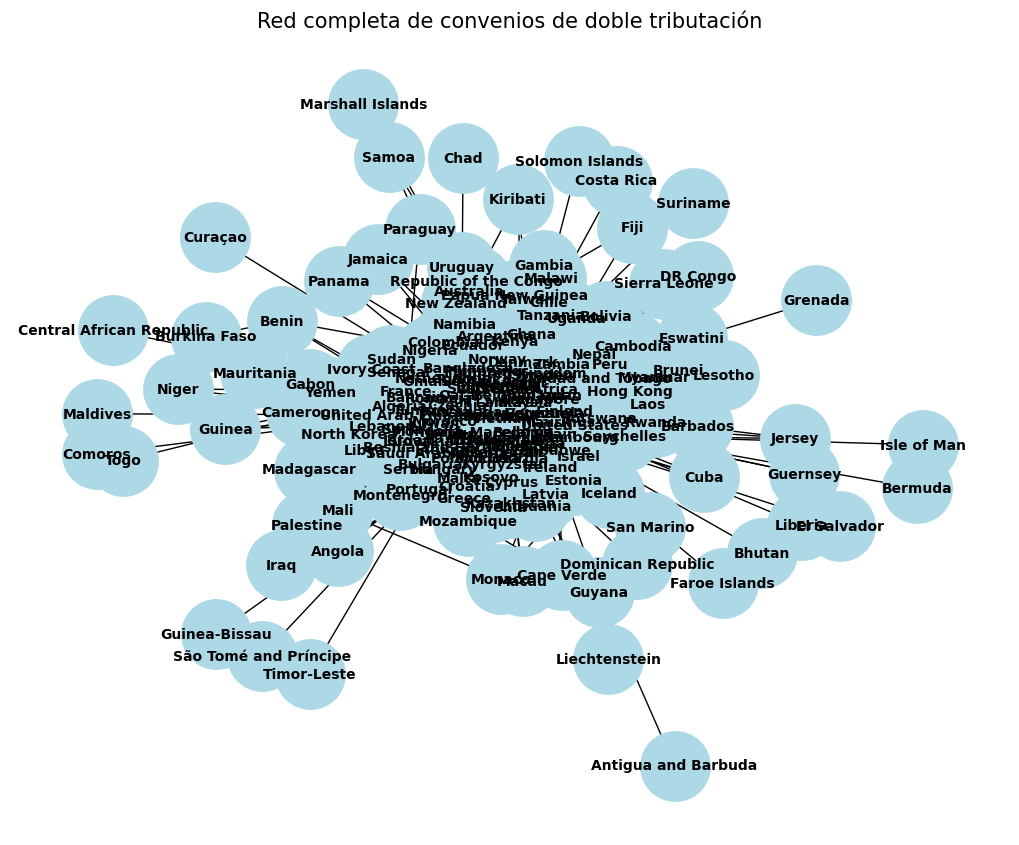

In [8]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2500, font_size=10, font_weight='bold')
plt.title("Red completa de convenios de doble tributación", size=15)
plt.show()

## Subgrafo para los paises con más volumen comercial actual con Colombia

Datos obtenidos del DANE

https://www.dane.gov.co/index.php/estadisticas-por-tema/comercio-internacional/exportaciones

### Exportaciones

In [9]:
# Lista de nodos para el subgrafo
paises_subgrafo = ['Colombia', 'United States', 'Panama', 'China', 'India', 'Brazil', 'Ecuador', 'Netherlands', 'Mexico', 'Turkey',
                   'Chile', 'Peru', 'Spain', 'Italy', 'South Korea', 'Canada', 'Germany', 'Venezuela', 'Dominican Republic',
                   'Belgium', 'Japan', 'Israel', 'United Kingdom']

# Crear el subgrafo
subgrafo = G.subgraph(paises_subgrafo)


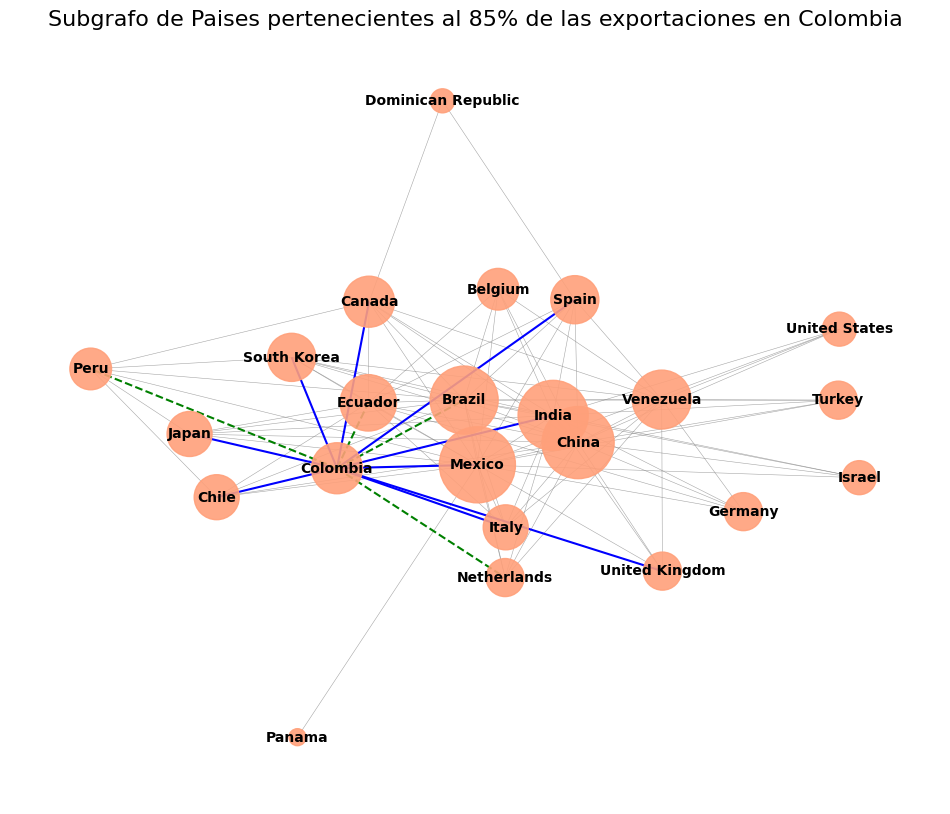

In [10]:
nodo_colombia='Colombia'

node_degrees = dict(subgrafo.degree())
node_sizes = [v * 150 for v in node_degrees.values()]

# 2. AJUSTAR EL LAYOUT
pos = nx.spring_layout(subgrafo, k=0.4, iterations=100, seed=42)

colombia_edges = [(u, v) for u, v in subgrafo.edges() if u == nodo_colombia or v == nodo_colombia]
# 3. DIBUJAR
plt.figure(figsize=(12, 10))

# Nodos
nx.draw_networkx_nodes(
    subgrafo, pos,
    node_size=node_sizes,
    node_color='lightsalmon',
    alpha=0.9
)

# Enlaces
nx.draw_networkx_edges(
    subgrafo, pos,
    width=0.4,
    alpha=0.7,
    edge_color='gray'
)

nx.draw_networkx_edges(
    subgrafo, pos,
    edgelist=colombia_edges,
    width=1.5,
    alpha=1.0,
    edge_color='blue',
    style='solid'
)

nuevas_aristas = [
    ('Colombia', 'Peru'),
    ('Colombia', 'Brazil'),
    ('Colombia', 'Ecuador'),
    ('Colombia', 'Netherlands')
]

nx.draw_networkx_edges(
    subgrafo, pos,
    edgelist=nuevas_aristas,
    width=1.5,
    alpha=1.0,
    edge_color='green',
    style='dashed'            # línea punteada para convenios firmados pero no en vigor
)

# Etiquetas: Texto más claro
nx.draw_networkx_labels(
    subgrafo, pos,
    font_size=10,
    font_weight='bold',
    font_color='black'
)

plt.title("Subgrafo de Paises pertenecientes al 85% de las exportaciones en Colombia", fontsize=16)
plt.axis('off')
plt.show()

### Importaciones

In [11]:
paises_subgrafo = ['Colombia', 'United States', 'China', 'Brazil', 'Mexico', 'Germany', 'France', 'India', 'Japan',
                   'Argentina', 'Spain', 'Italy', 'Canada', 'Vietnam', 'South Korea', 'Peru', 'Ecuador',
                   'Chile', 'United Kingdom']

# Crear el subgrafo
subgrafo = G.subgraph(paises_subgrafo)

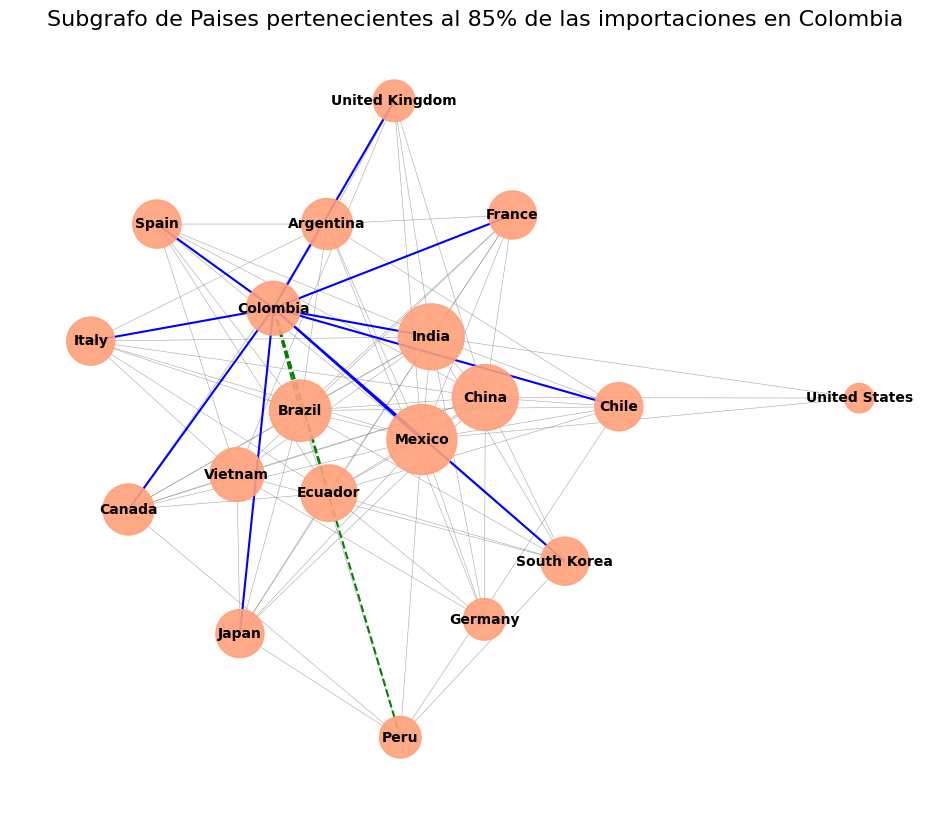

In [12]:
node_degrees = dict(subgrafo.degree())
# Escalar los tamaños: Multiplica por un factor para que sean visualmente distintos
node_sizes = [v * 150 for v in node_degrees.values()]



# 2. AJUSTAR EL LAYOUT
pos = nx.spring_layout(subgrafo, k=0.4, iterations=50, seed=42)

colombia_edges = [(u, v) for u, v in subgrafo.edges() if u == nodo_colombia or v == nodo_colombia]
# 3. DIBUJAR
plt.figure(figsize=(12, 10))

# Nodos
nx.draw_networkx_nodes(
    subgrafo, pos,
    node_size=node_sizes,
    node_color='lightsalmon',  # Color más suave
    alpha=0.9
)

# Enlaces
nx.draw_networkx_edges(
    subgrafo, pos,
    width=0.4,
    alpha=0.7,
    edge_color='gray'
)

nx.draw_networkx_edges(
    subgrafo, pos,
    edgelist=colombia_edges,
    width=1.5,
    alpha=1.0,
    edge_color='blue',
    style='solid'
)

nuevas_aristas = [
    ('Colombia', 'Peru'),
    ('Colombia', 'Brazil'),
    ('Colombia', 'Ecuador')
]

nx.draw_networkx_edges(
    subgrafo, pos,
    edgelist=nuevas_aristas,
    width=1.5,
    alpha=1.0,
    edge_color='green',
    style='dashed'
)

# Etiquetas
nx.draw_networkx_labels(
    subgrafo, pos,
    font_size=10,
    font_weight='bold',
    font_color='black'
)

plt.title("Subgrafo de Paises pertenecientes al 85% de las importaciones en Colombia", fontsize=16)
plt.axis('off')
plt.show()

## Subgrafo paises vecinos de Colombia

Este grafo representa aquellos paises cercanos a Colombia y los acuerdos para evitar la doble tributación que tienen con otros paises

In [13]:
G = nx.from_pandas_edgelist(base_convenios,
                            source='Country A',
                            target='Country B')

nodo_principal = 'Colombia'

# Verificar que el nodo exista en el grafo
if nodo_principal not in G:
    print(f"Error: El nodo '{nodo_principal}' no existe en el grafo actual.")
else:
    # VECINOS DE PRIMER ORDEN (Grado 1)
    # Los vecinos directos son los países con los que Colombia tiene un CDT
    vecinos_primer_orden = set(G.neighbors(nodo_principal))

    print(f"--- Vecinos de Primer Orden de {nodo_principal} ---")
    print(f"Total: {len(vecinos_primer_orden)}")
    print(vecinos_primer_orden)


    # VECINOS DE SEGUNDO ORDEN (Grado 2)
    # Los vecinos de los vecinos directos
    vecinos_segundo_orden = set()

    # Iterar sobre cada vecino de primer orden
    for vecino in vecinos_primer_orden:
        # Obtener los vecinos del vecino actual
        vecinos_segundo_orden.update(G.neighbors(vecino))

    # Excluir los vecinos de primer orden y el nodo principal (COL)
    vecinos_segundo_orden = vecinos_segundo_orden - vecinos_primer_orden
    vecinos_segundo_orden.discard(nodo_principal)


    print("\n--- Vecinos de Segundo Orden de COL (Excluyendo vecinos de Grado 1) ---")
    print(f"Total: {len(vecinos_segundo_orden)}")
    print(vecinos_segundo_orden)

--- Vecinos de Primer Orden de Colombia ---
Total: 13
{'Mexico', 'Italy', 'Switzerland', 'Chile', 'Czechia', 'United Kingdom', 'France', 'Spain', 'Japan', 'Canada', 'South Korea', 'India', 'Portugal'}

--- Vecinos de Segundo Orden de COL (Excluyendo vecinos de Grado 1) ---
Total: 140
{'Central African Republic', 'Trinidad and Tobago', 'Ireland', 'Mauritania', 'Syria', 'Taiwan', 'Hungary', 'Angola', 'Timor-Leste', 'Singapore', 'United Arab Emirates', 'Niger', 'Luxembourg', 'Kosovo', 'Ecuador', 'Malawi', 'Oman', 'Paraguay', 'Slovenia', 'Ethiopia', 'Tanzania', 'Bolivia', 'Finland', 'Benin', 'Kyrgyzstan', 'Malta', 'Morocco', 'Belarus', 'Mauritius', 'Sudan', 'Estonia', 'Cape Verde', 'Iran', 'Gambia', 'Poland', 'Cambodia', 'Cameroon', 'Bhutan', 'Belgium', 'Mali', 'North Korea', 'Egypt', 'Armenia', 'Eswatini', 'Israel', 'Namibia', 'New Zealand', 'Guinea', 'Laos', 'Cyprus', 'Sweden', 'Tunisia', 'Indonesia', 'Romania', 'Senegal', 'Togo', 'Albania', 'Austria', 'Madagascar', 'Iceland', 'Australia

In [14]:
nodos_interes={nodo_principal} | vecinos_primer_orden
nodos_interes=nodos_interes | vecinos_segundo_orden

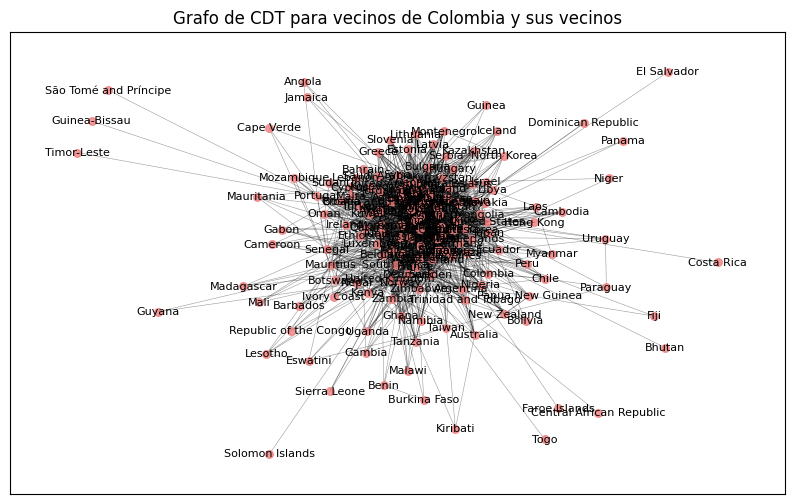

In [15]:
# Crear el subgrafo
subgrafo = G.subgraph(nodos_interes)
# 1. Calcular métrica para tamaño
node_degrees = dict(G.degree())
# Escalar el tamaño para la visualización
node_sizes = [v * 50 for v in node_degrees.values()]

# 2. Generar el layout
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 6))
# 3. Dibujar el grafo
nx.draw_networkx_nodes(
    subgrafo, pos,
    node_size=30,
    node_color='lightcoral', # Cambiar color
    alpha=0.8
)
nx.draw_networkx_edges(
    subgrafo, pos,
    width=0.4,
    alpha=0.4
)

nx.draw_networkx_labels(subgrafo, pos, font_size=8)
plt.title("Grafo de CDT para vecinos de Colombia y sus vecinos")
plt.show()

# Metricas del grafo para Colombia


In [16]:
metrics = {}

metrics['Grado'] = dict(subgrafo.degree())
metrics['Centralidad_de_Grado'] = nx.degree_centrality(subgrafo)
metrics['Coeficiente_de_Agrupamiento'] = nx.clustering(subgrafo)
metrics['Centralidad_de_Cercania'] = nx.closeness_centrality(subgrafo)
metrics['Centralidad_de_Intermediacion'] = nx.betweenness_centrality(subgrafo)

# Métricas Globales
try:
    avg_path = nx.average_shortest_path_length(subgrafo)
    print(f"AverageShortestPathLength: {avg_path}")
except nx.NetworkXError:
    # Esto ocurre si la red no está conectada
    print("La red no está conectada, no se puede calcular ASPL.")

# Métricas Simples y de Estructura
print(f"NumberOfUndirectedEdges: {subgrafo.number_of_edges()}")
print(f"SelfLoops: {nx.number_of_selfloops(subgrafo)}")

# Conversión a DataFrame para integrar con atributos de nodo
df_metrics = pd.DataFrame(metrics)
# El índice del DataFrame son los países (nodos)

print("\nDataFrame de Métricas Estructurales:")
df_metrics

AverageShortestPathLength: 2.017400899753841
NumberOfUndirectedEdges: 1903
SelfLoops: 0

DataFrame de Métricas Estructurales:


,Grado,Centralidad_de_Grado,Coeficiente_de_Agrupamiento,Centralidad_de_Cercania,Centralidad_de_Intermediacion
Albania,43,0.281046,0.234773,0.570896,0.006831
Israel,17,0.111111,0.500000,0.488818,0.000245
Turkey,36,0.235294,0.352381,0.538732,0.004301
Romania,37,0.241830,0.348348,0.538732,0.003362
Italy,46,0.300654,0.241546,0.560440,0.009328
...,...,...,...,...,...
Panama,2,0.013072,0.000000,0.411290,0.000004
Sierra Leone,3,0.019608,0.666667,0.442197,0.000008
Timor-Leste,1,0.006536,0.000000,0.344595,0.000000
São Tomé and Príncipe,1,0.006536,0.000000,0.344595,0.000000


# Coeficientes para la predicción de enlaces desde la red sin características exógenas


Metodología basada en el artículo de Nandini et al. (2024),

## Coeficiente de Jaccard

In [17]:
jaccard_scores = nx.jaccard_coefficient(subgrafo)

scores_list = []
for u, v, p in jaccard_scores:
    scores_list.append({'Pais_i': u, 'Pais_j': v, 'Jaccard_Score': p})

df_jaccard = pd.DataFrame(scores_list)
df_jaccard.sort_values(by=['Pais_i','Jaccard_Score'], ascending=[True, False], inplace=True)

In [18]:
df_jaccard[df_jaccard['Pais_i']=='Colombia']

,Pais_i,Pais_j,Jaccard_Score
9407,Colombia,Mongolia,0.258065
9403,Colombia,Philippines,0.244444
9387,Colombia,Bangladesh,0.243243
9400,Colombia,Ghana,0.238095
9402,Colombia,Kenya,0.227273
9388,Colombia,Algeria,0.195122
9394,Colombia,Turkmenistan,0.191489
9406,Colombia,Thailand,0.177419
9381,Colombia,Mozambique,0.176471
9399,Colombia,South Africa,0.173333


## Coeficiente de Adamic Adar

Código corregido con Gemini

In [19]:
nodo_colombia='Colombia'

aa_scores_generator = nx.adamic_adar_index(subgrafo)

# Relizar  el adamic adar para cada par de
scores_list = []
for u, v, score in aa_scores_generator:
    scores_list.append({
        'Pais_A': u,
        'Pais_B': v,
        'Adamic_Adar_Score': score
    })

df_adamic_adar = pd.DataFrame(scores_list)

# ver solo las predicciones de Colombia
df_colombia_aa = df_adamic_adar[
    (df_adamic_adar['Pais_A'] == nodo_colombia) |
    (df_adamic_adar['Pais_B'] == nodo_colombia)
]

# 4. Ordenar para ver los países con mayor probabilidad de firmar un CDT
df_colombia_aa_sorted = df_colombia_aa.sort_values(
    by='Adamic_Adar_Score',
    ascending=False
)

print(f"--- Top 5 Países Candidatos para CDT con {nodo_colombia} (Según Adamic-Adar) ---")
df_colombia_aa_sorted

--- Top 5 Países Candidatos para CDT con Colombia (Según Adamic-Adar) ---


,Pais_A,Pais_B,Adamic_Adar_Score
8347,China,Colombia,3.593753
9399,Colombia,South Africa,3.593753
9353,Brazil,Colombia,3.347475
6154,Indonesia,Colombia,3.176721
8406,Ukraine,Colombia,3.176721
...,...,...,...
8438,Malaysia,Colombia,0.217147
8853,Bulgaria,Colombia,0.217147
8957,Montenegro,Colombia,0.217147
8195,Kazakhstan,Colombia,0.217147


## Similaridad basada en centralidad promedio - SAC (Similarity based on Average Centrality)

In [22]:
# dividir entre tarin y test las aristas del subgrafod e colombia

aristas= list (subgrafo.edges())
num_aristas_test=int(len(aristas)*0.2)
aristas_test=aristas[:num_aristas_test]
aristas_train=aristas[num_aristas_test:]

# Crear grafo de entrenamiento

G_train = nx.Graph()
G_train.add_nodes_from(subgrafo.nodes())
G_train.add_edges_from(aristas_train)

# Generar aristas negativas (pares que NO están conectados) para evaluar el modelo
aristas_negativas_posibles = list(nx.non_edges(subgrafo))
aristas_test_negativas = random.sample(aristas_negativas_posibles, num_aristas_test)

# Nuestro conjunto de prueba completo (y_true: 1 para positivas, 0 para negativas)
test_edges = aristas_test + aristas_test_negativas
y_true = [1] * len(aristas_test) + [0] * len(aristas_test_negativas)

# metricas base para el SAC

grado = dict(G_train.degree())
cent_degree = nx.degree_centrality(G_train)
cent_clustering = nx.clustering(G_train)
cent_closeness = nx.closeness_centrality(G_train)
cent_betweenness = nx.betweenness_centrality(G_train)

# Metricas sobre el numero de nodos Ac(G)

promedio_degree = np.mean(list(cent_degree.values()))
promedio_clustering = np.mean(list(cent_clustering.values()))
promedio_closeness = np.mean(list(cent_closeness.values()))
promedio_betweenness = np.mean(list(cent_betweenness.values()))

def predict_sac(u, v, G, metric_dict, avg_metric):

    if u not in G or v not in G: return 0

    vecinos_comunes = list(nx.common_neighbors(G, u, v))
    puntaje_sac = 0

    for vecino in vecinos_comunes:
        # Filtrado por Umbral: Solo sumar si el vecino supera el promedio
        if metric_dict[vecino] >= avg_metric:
            puntaje_sac += 1

    return puntaje_sac

scores = {
    'SACD': [], 'SACB': [], 'SACC': [], 'SACCC': [],
    'JC': [], 'AA': []
}

for u, v in test_edges:
    # --- SAC Métricas ---
    scores['SACD'].append(predict_sac(u, v, G_train, cent_degree, promedio_degree))
    scores['SACB'].append(predict_sac(u, v, G_train, cent_betweenness, promedio_betweenness))
    scores['SACC'].append(predict_sac(u, v, G_train, cent_closeness, promedio_closeness))
    scores['SACCC'].append(predict_sac(u, v, G_train, cent_clustering, promedio_clustering))

    # Jaccard Coefficient (JC)
    jc_gen = nx.jaccard_coefficient(G_train, [(u, v)])
    scores['JC'].append(next(jc_gen)[2])

    # Adamic-Adar (AA)
    try:
        aa_gen = nx.adamic_adar_index(G_train, [(u, v)])
        scores['AA'].append(next(aa_gen)[2])
    except ZeroDivisionError:
        scores['AA'].append(0)


In [23]:
resultados = []
for metrica, predicciones in scores.items():
    auroc = roc_auc_score(y_true, predicciones)
    aupr = average_precision_score(y_true, predicciones)
    resultados.append({'Metrica': metrica, 'AUROC': auroc, 'AUPR': aupr})

df_resultados = pd.DataFrame(resultados).sort_values(by='AUROC', ascending=False)
df_resultados

,Metrica,AUROC,AUPR
3,SACCC,0.386863,0.484730
0,SACD,0.187902,0.476309
5,AA,0.187690,0.478466
2,SACC,0.186731,0.476949
4,JC,0.180997,0.474371
1,SACB,0.179605,0.474665


In [24]:
nodo_colombia = 'Colombia'
paises_sin_cdt = [
        nodo for nodo in subgrafo.nodes()
        if nodo != nodo_colombia and not subgrafo.has_edge(nodo_colombia, nodo)
]

predicciones_colombia = []

for candidato in paises_sin_cdt:
      vecinos_comunes = list(nx.common_neighbors(subgrafo, nodo_colombia, candidato))
      puntaje_saccc = 0

      # Lógica SACCC: Filtrar vecinos comunes por el umbral de clustering
      for vecino in vecinos_comunes:
          if cent_clustering[vecino] >= promedio_clustering:
              puntaje_saccc += 1

      predicciones_colombia.append({
            'Pais_Candidato': candidato,
            'Vecinos_Comunes_Total': len(vecinos_comunes),
            'Puntaje_SACCC': puntaje_saccc
        })


df_predicciones = pd.DataFrame(predicciones_colombia)


df_top_candidatos = df_predicciones.sort_values(
    by=['Puntaje_SACCC', 'Vecinos_Comunes_Total'],
    ascending=[False, False]
).reset_index(drop=True)

print(f" TOP 10 PAÍSES CANDIDATOS PARA CDT CON {nodo_colombia} (Métrica: SACCC)")
print(df_top_candidatos.head(10).to_string())


--- TOP 10 PAÍSES CANDIDATOS PARA CDT CON Colombia (Métrica: SACCC) ---
  Pais_Candidato  Vecinos_Comunes_Total  Puntaje_SACCC
0          China                     13              2
1   South Africa                     13              2
2         Brazil                     12              2
3       Thailand                     11              2
4        Ecuador                      9              2
5           Peru                      7              2
6      Indonesia                     12              1
7        Ukraine                     12              1
8        Morocco                     11              1
9    Philippines                     11              1
